In [1]:
import numpy as np
import math
thetas = np.arange(0.1, 1.0, 0.1)
theta = np.random.choice(thetas, 1)[0]

def create_samples(theta, n_patients, m_sessions):
    """
    Create a sample of patients with sessions based on the given theta value.
    
    Parameters:
    theta (float): The probability of a patient having a session.
    n_patients (int): The number of patients to sample.
    m_sessions (int): The number of sessions per patient.
    
    Returns:
    np.ndarray: A 2D array where each row represents a patient and each column represents a session.
    """
    return np.random.binomial(1, theta, size=(n_patients, m_sessions))

print(f"theta: {theta}")
print("samples:")
samples = create_samples(theta, 10, 5)
print(samples)
print("shape:", samples.shape)

theta: 0.8
samples:
[[1 1 1 0 1]
 [1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 1 0 1]
 [1 1 1 1 1]
 [1 1 1 1 0]
 [1 0 1 1 1]
 [1 1 1 0 1]
 [1 1 1 1 0]]
shape: (10, 5)


In [2]:
def literal_speaker_theta(obs, thetas=thetas):
    n = obs.shape[0]
    m = obs.shape[1]
    sum_obs = np.sum(obs)
    posterirors = np.zeros(len(thetas))
    for theta in thetas:
        # Calculate the likelihood of the observed data given theta
        likelihood = math.comb(m * n, sum_obs) * theta ** (sum_obs) * (1 - theta) ** (m * n - sum_obs)
        prior = 1 / len(thetas)
        posterior = likelihood * prior
        posterirors[int(theta * 10 - 1)] = posterior

    return posterirors / np.sum(posterirors)

print("posterior:")
posteriors = literal_speaker_theta(samples)
print(theta)
print(posteriors)
print(sum(posteriors))
    
    

posterior:
0.8
[1.20144674e-33 2.05941637e-21 1.76052204e-14 9.06763617e-10
 2.47893229e-06 8.80231476e-04 5.71284138e-02 6.07832428e-01
 3.34156446e-01]
1.0


In [3]:
def literal_speaker_utterance(obs, thetas=thetas):
    probs = np.zeros(shape=(4, 4, 2))
    obs_sum = np.sum(obs)
    full_effective = (np.sum(obs, axis = 1) == obs.shape[1]).sum()
    mostly_effective = (np.sum(obs, axis = 1) > obs.shape[1] / 2).sum()
    some_effective = (np.sum(obs, axis = 1) > 0).sum()
    none_effective = (np.sum(obs, axis = 1) == 0).sum()
    
    full_ineffective = (np.sum(obs, axis = 1) == 0).sum()
    mostly_ineffective = (np.sum(obs, axis = 1) < obs.shape[1] / 2).sum()
    some_ineffective = (np.sum(obs, axis = 1) < obs.shape[1]).sum()
    none_ineffective = (np.sum(obs, axis = 1) == obs.shape[1]).sum()
    
    
    total_cells = obs.shape[0] * obs.shape[1]
    half_rows = obs.shape[0] / 2

    conditions = {
        ("all", "all", "effective"): (obs_sum == total_cells),
        ("all", "most", "effective"): (mostly_effective == obs.shape[0]),
        ("all", "some", "effective"): (some_effective == obs.shape[0]),
        ("all", "none", "effective"): (none_effective == obs.shape[0]),

        ("most", "all", "effective"): full_effective > half_rows,
        ("most", "most", "effective"): mostly_effective > half_rows,
        ("most", "some", "effective"): some_effective > half_rows,
        ("most", "none", "effective"): none_effective > half_rows,

        ("some", "all", "effective"): full_effective > 0,
        ("some", "most", "effective"): mostly_effective > 0,
        ("some", "some", "effective"): some_effective > 0,
        ("some", "none", "effective"): none_effective > 0,

        ("none", "all", "effective"): full_effective == 0,
        ("none", "most", "effective"): mostly_effective == 0,
        ("none", "some", "effective"): some_effective == 0,
        ("none", "none", "effective"): none_effective == 0,

        ("all", "all", "ineffective"): (obs_sum == 0),
        ("all", "most", "ineffective"): (mostly_ineffective == obs.shape[0]),
        ("all", "some", "ineffective"): (some_ineffective == obs.shape[0]),
        ("all", "none", "ineffective"): (none_ineffective == obs.shape[0]),

        ("most", "all", "ineffective"): full_ineffective > half_rows,
        ("most", "most", "ineffective"): mostly_ineffective > half_rows,
        ("most", "some", "ineffective"): some_ineffective > half_rows,
        ("most", "none", "ineffective"): none_ineffective > half_rows,

        ("some", "all", "ineffective"): full_ineffective > 0,
        ("some", "most", "ineffective"): mostly_ineffective > 0,
        ("some", "some", "ineffective"): some_ineffective > 0,
        ("some", "none", "ineffective"): none_ineffective > 0,

        ("none", "all", "ineffective"): full_ineffective == 0,
        ("none", "most", "ineffective"): mostly_ineffective == 0,
        ("none", "some", "ineffective"): some_ineffective == 0,
        ("none", "none", "ineffective"): none_ineffective == 0,
    }

    true_keys = [k for k, v in conditions.items() if v]
    num_true = len(true_keys)

    if num_true == 0:
        # Handle edge case: no condition is true
        return {list(k): 0.0 for k in conditions}

    prob = 1.0 / num_true

    # Return a dictionary with lists as keys for clarity
    distribution = {k: (prob if k in true_keys else 0.0) for k in conditions}

    return distribution
    
    if full_effective > 0:
        probs[0, 0] = full_effective / obs.shape[0]

    return utterances / np.sum(utterances)

In [4]:
import numpy as np
from itertools import product

quantifiers = ["none", "some", "most", "all"]
predicates = ["effective", "ineffective"]

# Create a full list of utterance keys for reference
utterance_keys = list(product(quantifiers, quantifiers, predicates))

def create_samples(theta, n, m):
    """Simulate n patients × m sessions with improvement probability theta"""
    return np.random.binomial(1, theta, size=(n, m))

def utterance_is_true(u, obs):
    """Evaluate if utterance u = (q1, q2, pred) is true given obs[n x m]"""
    if obs.shape[0] > 1:
        q1, q2, pred = u
        n, m = obs.shape

        if pred == "effective":
            patient_scores = obs.sum(axis=1)
        else:  # "ineffective"
            patient_scores = m - obs.sum(axis=1)

        # Step 1: apply q2 to each patient
        if q2 == "none":
            patient_truths = patient_scores == 0
        elif q2 == "some":
            patient_truths = patient_scores > 0
        elif q2 == "most":
            patient_truths = patient_scores > (m / 2)
        elif q2 == "all":
            patient_truths = patient_scores == m

        # Step 2: apply q1 across patients
        k = np.sum(patient_truths)
        if q1 == "none":
            return k == 0
        elif q1 == "some":
            return k >= 1
        elif q1 == "most":
            return k > (n / 2)
        elif q1 == "all":
            return k == n
    else:
        """Evaluate if utterance u = (q2, pred) is true given obs[1 x m]"""
        q2, pred = u
        m = obs.shape[1]
        patient_score = obs[0].sum() if pred == "effective" else m - obs[0].sum()

        if q2 == "none":
            return patient_score == 0
        elif q2 == "some":
            return patient_score > 0
        elif q2 == "most":
            return patient_score > (m / 2)
        elif q2 == "all":
            return patient_score == m

def literal_speaker_utterance_obs(obs, quantifiers=quantifiers, predicates=predicates):
    """Return uniform distribution over all true utterances"""
    if obs.shape[0] > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))
    true_utterances = [u for u in utterances if utterance_is_true(u, obs)]
    if not true_utterances:
        return {}
    p = 1.0 / len(true_utterances)
    return {u: p for u in true_utterances}

def literal_speaker_utterance_theta(theta, n, m, N=1000, quantifiers=quantifiers, predicates=predicates):
    """Estimate literal speaker utterance distribution given theta via sampling"""
    if n > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))
        
    probs = {u: 0.0 for u in utterances}
    for _ in range(N):
        obs = create_samples(theta, n, m)
        distribution = literal_speaker_utterance_obs(obs)
        for key, value in distribution.items():
            probs[key] += (value * (theta ** np.sum(obs)) * ((1 - theta) ** (obs.size - np.sum(obs)))) / N
    return probs

def literal_listener_theta_utterance(utterance, n = 10, m = 20, thetas=thetas, N=1000):
    probs = {}
    for theta in thetas:
        utterance_probs = literal_speaker_utterance_theta(theta, n=n, m=m, N=N)
        probs[theta] = utterance_probs.get(tuple(utterance), 0.0) / len(thetas)
    total = sum(probs.values())
    return [p / total for p in probs.values()]

from itertools import product
import numpy as np

def informativeness_all_utterances(obs, thetas, quantifiers=["none", "some", "most", "all"], N=1000):
    if obs.shape[0] > 1:
        utterances = list(product(quantifiers, quantifiers, ["effective", "ineffective"]))
    else:
        utterances = list(product(quantifiers, ["effective", "ineffective"]))
    result = {}
    print(f"obs shape: {obs.shape}, utterances: {len(utterances)}")
    total_successes = np.sum(obs)
    total_trials = obs.size

    for utt in utterances:
        if utterance_is_true(utt, obs):
            print(utt)
            theta_utt = literal_listener_theta_utterance(
                utt, n=obs.shape[0], m=obs.shape[1], thetas=thetas, N=N
            )
            info = 0.0
            for i, theta in enumerate(thetas):
                p_obs_given_theta = math.comb(obs.size, total_successes)* (theta ** total_successes) * ((1 - theta) ** (total_trials - total_successes))
                info += p_obs_given_theta * theta_utt[i]
            result[utt] = info
        else:
            result[utt] = 0.0

    return result


def pragmatic_speaker1_softmax(informativity_dict, alpha=1.0):
    utterances = list(informativity_dict.keys())
    probs = []
    for utt, info in informativity_dict.items():
        if info > 0:
            probs.append(info ** alpha)
        else:
            probs.append(0.0)
    probs = np.array(probs)
    probs /= np.sum(probs)  # Normalize to ensure probabilities sum to 1
    
    
    # infos = np.array([informativity_dict[u] for u in utterances])

    # infos_nonzero = infos[infos > 0]
    # # Softmax with temperature (α): exponentiate scaled informativeness
    # scaled = alpha * infos
    # # scaled -= np.max(scaled)  # For numerical stability
    # exp_scaled = np.exp(scaled)
    # exp_scaled.map(lambda x: 0 if x == 1 else x)  # Avoid division by zero
    # probs = exp_scaled / np.sum(exp_scaled)

    return {u: p for u, p in zip(utterances, probs)}

In [5]:
from scipy.special import binom

def multinomial(params):
    if len(params) == 1:
        return 1
    return binom(sum(params), params[-1]) * multinomial(params[:-1])

In [6]:
print("Multinomial coefficient for (2, 3, 4):", multinomial([2, 3, 4]))

Multinomial coefficient for (2, 3, 4): 1260.0


In [7]:
from itertools import product
quantifiers = ["none", "some", "most", "all"]
predicates = ["effective", "ineffective"]

def generate_all_observations(n, m):
    """
    Generate all possible observation histograms for n patients and m sessions.
    Each histogram is a tuple of length m+1, summing to n.
    """
    observations = []

    def helper(current, depth, remaining):
        if depth == m:
            current.append(remaining)
            observations.append(tuple(current))
            current.pop()
            return
        for i in range(remaining + 1):
            current.append(i)
            helper(current, depth + 1, remaining - i)
            current.pop()

    helper([], 0, n)
    return observations

def utterance_is_true(u, obs):
    """Evaluate if utterance u = (q1, q2, pred) is true given obs[n x m]"""
    if sum(obs) > 1:
        q1, q2, pred = u
        n = sum(obs)
        m = len(obs) - 1
        k = 0
        if pred == "ineffective":
            obs = obs[::-1]  # Reverse obs to treat "ineffective" as the last element
        
        # Step 1: apply q2 to each patient
        if q2 == "none":
            k = obs[0]
        elif q2 == "some":
            k = sum(obs[1:])
        elif q2 == "most":
            k = sum(obs[math.floor(m / 2) + (m % 2) : ])
        elif q2 == "all":
            k = obs[-1]

        # Step 2: apply q1 across patients
        if q1 == "none":
            return k == 0
        elif q1 == "some":
            return k >= 1
        elif q1 == "most":
            return k > (n / 2)
        elif q1 == "all":
            return k == n
    else:
        """Evaluate if utterance u = (q2, pred) is true given obs[1 x m]"""
        q2, pred = u
        m = len(obs) - 1
        patient_score = obs.index(1) if pred == "effective" else m - obs.index(1)

        if q2 == "none":
            return patient_score == 0
        elif q2 == "some":
            return patient_score > 0
        elif q2 == "most":
            return patient_score > (m / 2)
        elif q2 == "all":
            return patient_score == m

def literal_speaker_utterance_obs(obs, quantifiers=quantifiers, predicates=predicates):
    """Return uniform distribution over all true utterances"""
    if sum(obs) > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))
    true_utterances = [u for u in utterances if utterance_is_true(u, obs)]
    if not true_utterances:
        return {}
    p = 1.0 / len(true_utterances)
    result = {}
    for u in utterances:
        if u in true_utterances:
            result[u] = p
        else:
            result[u] = 0.0
    return result

def literal_speaker_utterance_theta(theta, n, m, quantifiers=quantifiers, predicates=predicates, N = 1000):
    """Estimate literal speaker utterance distribution given theta via sampling"""
    if n > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))
        
    probs = {u: 0.0 for u in utterances}
    obs_probs = np.zeros(len(utterances))
    for i in range(len(obs_probs)):
        obs_probs[i] = math.comb(m, i) * (theta ** i) * ((1 - theta) ** (m - i))
    observations = generate_all_observations(n, m)
    for obs in observations:
        total_success = 0
        for i in range(len(obs)):
            total_success += obs[i] * i
        for key, value in literal_speaker_utterance_obs(obs).items():
            probs[key] += value * math.comb(n * m, total_success) * (theta ** total_success) * ((1 - theta) ** (n * m - total_success))
    return probs

def literal_listener_theta_utterance(utterance, n = 10, m = 20, thetas=thetas, N = 1000):
    probs = {}
    for theta in thetas:
        utterance_probs = literal_speaker_utterance_theta(theta, n=n, m=m)
        probs[theta] = utterance_probs.get(tuple(utterance), 0.0) / len(thetas)
    total = sum(probs.values())
    return [p / total for p in probs.values()]

def informativeness_all_utterances(obs, thetas, quantifiers=["none", "some", "most", "all"], N=1000):
    if sum(obs) > 1:
        utterances = list(product(quantifiers, quantifiers, ["effective", "ineffective"]))
    else:
        utterances = list(product(quantifiers, ["effective", "ineffective"]))
    result = {}
    total_success = 0
    for i in range(len(obs)):
        total_success += obs[i] * i
    total_trials = len(obs) - 1
    n = sum(obs)
    m = len(obs) - 1

    for utt in utterances:
        if utterance_is_true(utt, obs):
            print(utt)
            theta_utt = literal_listener_theta_utterance(
                utt, n=n, m=m, thetas=thetas, N=N
            )
            info = 0.0
            for i, theta in enumerate(thetas):
                p_obs_given_theta = math.comb(n * m, total_success) * (theta ** total_success) * ((1 - theta) ** (n * m - total_success))
                info += p_obs_given_theta * theta_utt[i]
            result[utt] = info
        else:
            result[utt] = 0.0

    return result

def informativeness_all_utterances(obs, thetas, quantifiers=["none", "some", "most", "all"], N=1000):
    if sum(obs) > 1:
        utterances = list(product(quantifiers, quantifiers, ["effective", "ineffective"]))
    else:
        utterances = list(product(quantifiers, ["effective", "ineffective"]))
    result = {}
    total_success = 0
    for i in range(len(obs)):
        total_success += obs[i] * i
    total_trials = len(obs) - 1
    n = sum(obs)
    m = len(obs) - 1
    literal_speaker_utterance_obs_val = literal_speaker_utterance_obs(obs, quantifiers, ["effective", "ineffective"])
    all_obs = generate_all_observations(n, m)
    for utt in utterances:
        literal_listener_obs = 0
        for theta in thetas:
            literal_listener_obs += math.comb(n * m, total_success) * theta ** total_success * (1 - theta) ** (n * m - total_success) * (1 / len(thetas))
        literal_listener_utt = 0
        for obs_case in all_obs:
            literal_speaker_utterance_obscase_val = literal_speaker_utterance_obs(obs_case, quantifiers, ["effective", "ineffective"])
            for theta_case in thetas:
                literal_listener_utt += literal_speaker_utterance_obscase_val[utt] * math.comb(n * m, total_success) * theta_case ** total_success * (1 - theta_case) ** (n * m - total_success) / len(thetas)
        result[utt] = literal_speaker_utterance_obs_val[utt] * literal_listener_obs / literal_listener_utt
    return result

def persuasiveness_all_utterances(pers, n = 10, m = 20, thetas=thetas, quantifiers=["none", "some", "most", "all"], predicates=["effective", "ineffective"], N = 1000):
    if n > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))
        
    result = {u: 0.0 for u in utterances}

    for utt in utterances:
        if pers == "inf":
            result[utt] = 1
        elif pers == "high":
            theta_dist = literal_listener_theta_utterance(utt, n=n, m=m, thetas=thetas, N=N)
            for i in range(len(theta_dist)):
                result[utt] += theta_dist[i] * thetas[i]
        elif pers == "low":
            theta_dist = literal_listener_theta_utterance(utt, n=n, m=m, thetas=thetas, N=N)
            for i in range(len(theta_dist)):
                result[utt] += theta_dist[i] * thetas[i]
            result[utt] = 1 - result[utt]
    return result

def pragmatic_speaker_utt_obs(obs, pers, alpha=1.0, beta=1.0, thetas=np.linspace(0.1, 1.0, 10), N=1000):
    n = sum(obs)
    m = len(obs) - 1
    quantifiers = ["none", "some", "most", "all"]
    predicates = ["effective", "ineffective"]

    # Get utterance space
    if n > 1:
        utterances = list(product(quantifiers, quantifiers, predicates))
    else:
        utterances = list(product(quantifiers, predicates))

    # Compute informativeness and persuasiveness
    informativity_dict = informativeness_all_utterances(obs, thetas, quantifiers=quantifiers, N=N)
    persuasiveness_dict = persuasiveness_all_utterances(pers, n=n, m=m, thetas=thetas, quantifiers=quantifiers, predicates=predicates, N=N)

    # Compute softmax weights
    scores = []
    for utt in utterances:
        info = informativity_dict.get(utt, 0.0)
        pers_val = persuasiveness_dict.get(utt, 0.0)

        if info > 0:
            score = (info ** (alpha * beta)) * (pers_val ** (alpha * (1 - beta)))
        else:
            score = 0.0
        scores.append(score)

    scores = np.array(scores)
    probs = scores / np.sum(scores) if np.sum(scores) > 0 else np.ones_like(scores) / len(scores)

    return {utt: p for utt, p in zip(utterances, probs)}


In [8]:
obs = (1, 0, 0, 0, 0, 0, 0, 0) # e.g. 5 patients with session-level success counts
speaker_dist = pragmatic_speaker_utt_obs(obs, pers="high", alpha=3.0, beta=0.6)

# Print top utterances
for utt, p in sorted(speaker_dist.items(), key=lambda x: -x[1]):
    if p > 0.01:
        print(f"{utt}: {p:.3f}")

('none', 'effective'): 0.456
('all', 'ineffective'): 0.456
('most', 'ineffective'): 0.056
('some', 'ineffective'): 0.032


In [9]:
import matplotlib.pyplot as plt
def pragmatic_listener_theta_psi_utt(utterance, thetas, psis, omega, n = 1, m = 7, alpha = 3.0):
    joint = {}
    all_observations = generate_all_observations(n = n, m = m)
    for theta, psi in product(thetas, psis):
        middle = 0
        if psi == "inf":
            beta = 1.0
        else:
            beta = 0.0
        for obs in all_observations:
            total_success = sum([i * obs[i] for i in range(len(obs))])
            obs_prob = math.comb(n * m, total_success) * (theta ** total_success) * (1 - theta) ** (n * m - total_success)
            middle += pragmatic_speaker_utt_obs(obs, pers=psi, alpha=alpha, beta=beta, thetas=thetas)[utterance] * obs_prob
        if omega == "strat":
            joint[psi, theta] = middle * (1 / len(thetas)) * (1 / len(psis))
        elif omega == "coop":
            if psi == "inf":
                joint[psi, theta] = middle * (1 / len(thetas))
            else:
                joint[psi, theta] = 0

    total = sum(joint.values())
    return {k: v / total for k, v in joint.items()}

def pragmatic_listener_theta_utt(joint):
    theta_probs = {}
    for (psi, theta), prob in joint.items():
        theta_probs[theta] = theta_probs.get(theta, 0.0) + prob
    return theta_probs

def pragmatic_listener_psi_utt(joint):
    psi_probs = {}
    for (psi, theta), prob in joint.items():
        psi_probs[psi] = psi_probs.get(psi, 0.0) + prob
    return psi_probs

def plot_literal_listener_theta_posterior(probs, thetas, utterance):
    """Plot posterior distribution over θ given an utterance."""
    plt.figure(figsize=(8, 4))
    plt.plot(thetas, probs, marker='o', color='blue', linewidth=2)
    if len(utterance) == 3:
        plt.title(f"Literal Listener Posterior: P(θ | {utterance[0]}-{utterance[1]} {utterance[2]})")
    else:
        plt.title(f"Literal Listener Posterior: P(θ | {utterance[0]} {utterance[1]})")
    plt.xlabel("θ (Effectiveness rate)")
    plt.ylabel("P(θ | utterance)")
    plt.xticks(thetas)
    plt.ylim(0, max(probs) * 1.1)  # Adjust y-axis limit for better visibility
    plt.grid(True)
    plt.tight_layout()
    plt.show()


{'high': np.float64(0.4748764271635851), 'low': np.float64(0.3987841279309032), 'inf': np.float64(0.1263394449055118)}
High Persuasiveness: 0.21680142692169557, Low Persuasiveness: 0.29581706784229805, Informative: 0.06324037250550295


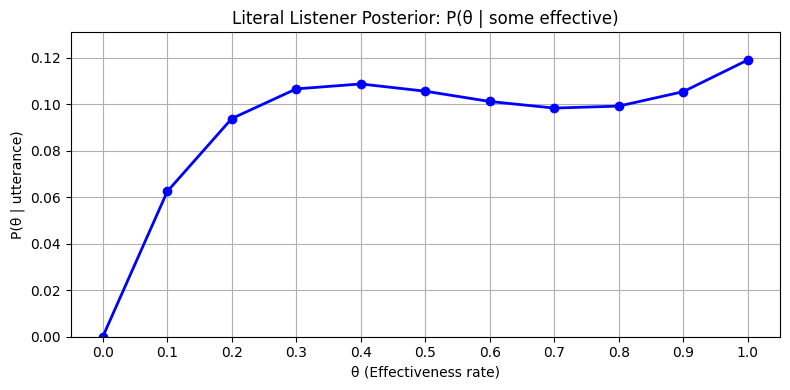

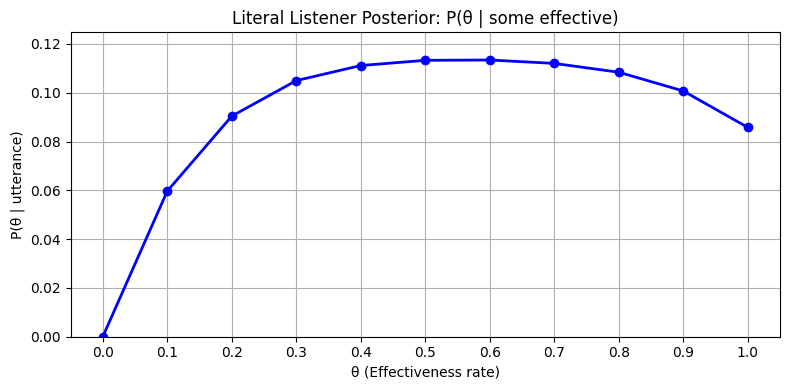

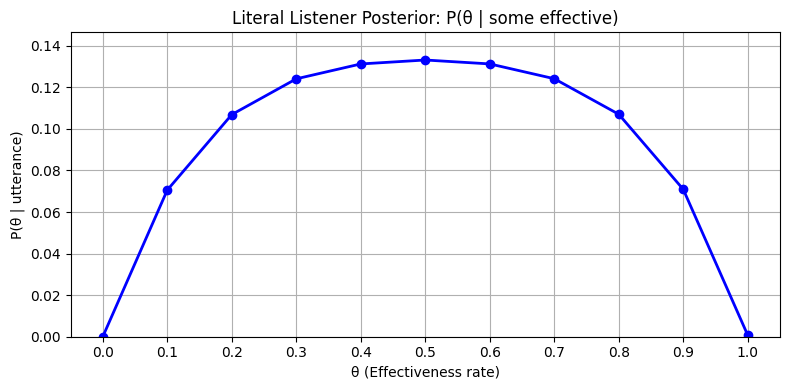

In [10]:
utterance = ("some", "effective")
thetas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
psis = ["high", "low", "inf"]
n = 1
m = 7
alpha = 3.0

joint = pragmatic_listener_theta_psi_utt(utterance=utterance, thetas=thetas, psis=psis, omega = "strat", n=n, m=m, alpha=alpha)
theta_dist = [p for p in pragmatic_listener_theta_utt(joint).values()]
psis_dist = pragmatic_listener_psi_utt(joint)
print(psis_dist)
high_psi = 0
low_psi = 0
inf_psi = 0
for (psi, theta), prob in joint.items():
    if psi == "high":
        high_psi += theta * prob
    elif psi == "low":
        low_psi += theta * prob 
    elif psi == "inf":
        inf_psi += theta * prob
print(f"High Persuasiveness: {high_psi}, Low Persuasiveness: {low_psi}, Informative: {inf_psi}")
plot_literal_listener_theta_posterior(theta_dist, thetas, utterance)

theta_dist = literal_listener_theta_utterance(utterance, n=n, m=m, thetas=thetas)
plot_literal_listener_theta_posterior(theta_dist, thetas, utterance)

joint = pragmatic_listener_theta_psi_utt(utterance=utterance, thetas=thetas, psis=psis, omega = "coop", n=n, m=m, alpha=alpha)
theta_dist = [p for p in pragmatic_listener_theta_utt(joint).values()]
plot_literal_listener_theta_posterior(theta_dist, thetas, utterance)

In [11]:
print(literal_listener_theta_utterance(("some", "effective"), n=1, m=7, thetas=thetas, N=1000))
print(sum(literal_listener_theta_utterance(("some", "effective"), n=1, m=7, thetas=thetas, N=1000)) / len(thetas))

print(persuasiveness_all_utterances("low", n = 1, m = 7, thetas=thetas, quantifiers=["none", "some", "most", "all"], predicates=["effective", "ineffective"], N = 1000))

[0.0, 0.05969179017463995, 0.09042178531548571, 0.10498816962202642, 0.11116735763911609, 0.11329981625317374, 0.11342897321672796, 0.1120364618921096, 0.10841695190509952, 0.1007358153993356, 0.08581287858228544]
0.09090909090909091
{('none', 'effective'): 0.9276957427715333, ('none', 'ineffective'): 0.07230425722846667, ('some', 'effective'): 0.433641580630317, ('some', 'ineffective'): 0.5663584193696829, ('most', 'effective'): 0.26701310311295967, ('most', 'ineffective'): 0.7329868968870403, ('all', 'effective'): 0.07230425722846667, ('all', 'ineffective'): 0.9276957427715333}


In [12]:
obs = observations[4]  # Example observation
utt = ("most", "ineffective")
is_true = utterance_is_true(utt, obs)
print(f"Is the utterance {utt} true for the first observation?\n {obs} \n {is_true}")

NameError: name 'observations' is not defined

In [ ]:
res = literal_speaker_utterance_theta(0.8, 1, 7)
sum_res = sum(res.values())
print(f"Sum of probabilities for utterances: {sum_res}")
print(res)

Sum of probabilities for utterances: 0.9999999999999998
{('none', 'effective'): 3.199999999999995e-06, ('none', 'ineffective'): 0.05242880000000002, ('some', 'effective'): 0.31585279999999993, ('some', 'ineffective'): 0.2634271999999999, ('most', 'effective'): 0.30474239999999997, ('most', 'ineffective'): 0.011113599999999993, ('all', 'effective'): 0.05242880000000002, ('all', 'ineffective'): 3.199999999999995e-06}


In [ ]:
res = literal_speaker_utterance_theta(0.8, 1, 7)
sum_res = sum(res.values())
print(f"Sum of probabilities for utterances: {sum_res}")
print(res)

Sum of probabilities for utterances: 0.06676751359999994
{('none', 'effective'): 0.0, ('none', 'ineffective'): np.float64(0.011010048000000001), ('some', 'effective'): np.float64(0.01858582186666663), ('some', 'ineffective'): np.float64(0.007575773866666697), ('most', 'effective'): np.float64(0.018578363733333287), ('most', 'ineffective'): np.float64(7.458133333333329e-06), ('all', 'effective'): np.float64(0.011010048000000001), ('all', 'ineffective'): 0.0}


In [ ]:
utterance = ("some", "effective")
observation = np.array([[0, 0, 0, 0, 0, 0, 0]])
dist = literal_speaker_utterance_obs(observation)
print(literal_listener_theta_utterance(utterance, n=1, m=7))
print(f"Utterance: {utterance}, Observation: {observation}, Distribution: {dist}")
utterance_is_true(utterance, observation)

NameError: name 'np' is not defined

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

def plot_utterance_histogram(distribution):
    quantifiers = ["none", "some", "most", "all"]
    preds = ["effective", "ineffective"]

    # Create x-axis labels from quantifier pairs
    x_labels = [f"{q1}-{q2}" for q1 in quantifiers for q2 in quantifiers]

    # Create y-values for both predicates
    values = {pred: [] for pred in preds}
    for q1 in quantifiers:
        for q2 in quantifiers:
            for pred in preds:
                prob = distribution.get((q1, q2, pred), 0.0)
                values[pred].append(prob)

    x = np.arange(len(x_labels))
    width = 0.35  # width of each bar

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(x - width/2, values["effective"], width, label="Effective", color="#4caf50")
    ax.bar(x + width/2, values["ineffective"], width, label="Ineffective", color="#f44336")

    ax.set_ylabel("Probability")
    ax.set_xlabel("Utterance (q1-q2)")
    ax.set_title("Literal Speaker Utterance Distribution")
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.legend()
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()



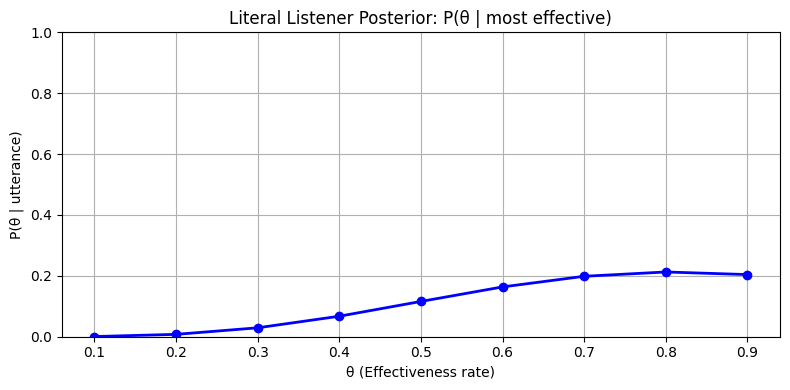

In [99]:
utt = ("most", "effective")
probs = literal_listener_theta_utterance(utt,thetas=thetas, n=1, m=7)
plot_literal_listener_theta_posterior(probs, thetas, utt)
#plot_utterance_histogram(probs)

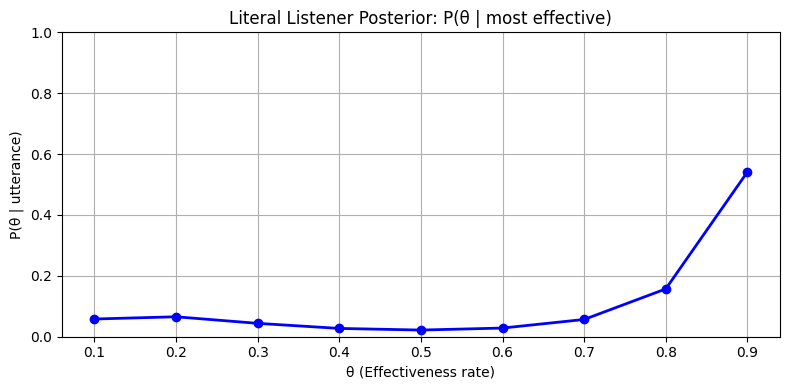

In [100]:
probs = literal_listener_theta_utterance(("some", "effective"),thetas=thetas, n=1, m=7, N=10000)
plot_literal_listener_theta_posterior(probs, thetas, ("most", "effective"))
#plot_utterance_histogram(probs)

In [62]:
def informativeness_speaker1(utterance, obs, thetas=thetas):
    if utterance_is_true(utterance, obs):
        theta_utt = literal_listener_theta_utterance(utterance, n=obs.shape[0], m=obs.shape[1], thetas=thetas)
        result = 0
        for theta in thetas:
            obs_theta = (theta ** np.sum(obs)) * ((1 - theta) ** (obs.size - np.sum(obs)))
            result += obs_theta * theta_utt[int(theta * 10 - 1)]
        return result
        
    else:
        return 0.0
    

In [13]:
from itertools import product
import numpy as np

def informativeness_all_utterances(obs, thetas, quantifiers=["none", "some", "most", "all"], N=1000):
    if obs.shape[0] > 1:
        utterances = list(product(quantifiers, quantifiers, ["effective", "ineffective"]))
    else:
        utterances = list(product(quantifiers, ["effective", "ineffective"]))
    result = {}
    print(f"obs shape: {obs.shape}, utterances: {len(utterances)}")
    total_successes = np.sum(obs)
    total_trials = obs.size

    for utt in utterances:
        if utterance_is_true(utt, obs):
            print(utt)
            theta_utt = literal_listener_theta_utterance(
                utt, n=obs.shape[0], m=obs.shape[1], thetas=thetas, N=N
            )
            info = 0.0
            for i, theta in enumerate(thetas):
                p_obs_given_theta = math.comb(obs.size, total_successes)* (theta ** total_successes) * ((1 - theta) ** (total_trials - total_successes))
                info += p_obs_given_theta * theta_utt[i]
            result[utt] = info
        else:
            result[utt] = 0.0

    return result


def pragmatic_speaker1_softmax(informativity_dict, alpha=1.0):
    utterances = list(informativity_dict.keys())
    probs = []
    for utt, info in informativity_dict.items():
        if info > 0:
            probs.append(info ** alpha)
        else:
            probs.append(0.0)
    probs = np.array(probs)
    probs /= np.sum(probs)  # Normalize to ensure probabilities sum to 1
    
    
    # infos = np.array([informativity_dict[u] for u in utterances])

    # infos_nonzero = infos[infos > 0]
    # # Softmax with temperature (α): exponentiate scaled informativeness
    # scaled = alpha * infos
    # # scaled -= np.max(scaled)  # For numerical stability
    # exp_scaled = np.exp(scaled)
    # exp_scaled.map(lambda x: 0 if x == 1 else x)  # Avoid division by zero
    # probs = exp_scaled / np.sum(exp_scaled)

    return {u: p for u, p in zip(utterances, probs)}

In [14]:
def plot_speaker_distribution(distribution, title="Speaker Distribution", alpha=1.0):
    """Plot speaker distribution over utterances (q2, predicate) in a fixed order."""
    utterance_order = [
        ("none", "ineffective"),
        ("none", "effective"),
        ("some", "ineffective"),
        ("some", "effective"),
        ("most", "ineffective"),
        ("most", "effective"),
        ("all", "ineffective"),
        ("all", "effective"),
    ]

    utterances = [f"{q2} {pred}" for (q2, pred) in utterance_order]
    probs = [distribution.get((q2, pred), 0.0) for (q2, pred) in utterance_order]

    plt.figure(figsize=(8, 5))
    bars = plt.barh(utterances, probs, color="steelblue")
    plt.xlabel("Probability")
    if alpha > 0:
        plt.title(f"{title} (α={alpha})")
    else:
        plt.title(title)
    plt.xlim(0, 1)

    # Add text labels
    for bar, prob in zip(bars, probs):
        if prob > 0.01:
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                     f"{prob:.2f}", va="center", fontsize=9)

    plt.gca().invert_yaxis()  # Keep top-down order
    plt.tight_layout()

In [15]:
obs = (1, 0, 0, 0, 0, 0, 0, 0)
print(obs)
infos = informativeness_all_utterances(obs, thetas=np.linspace(0.1, 1.0, 10), N = 10000)
perss = persuasiveness_all_utterances("high", n = 1, m = 7, thetas=np.linspace(0.1, 1.0, 10), quantifiers=["none", "some", "most", "all"], predicates=["effective", "ineffective"], N = 1000)
speaker1_dist = pragmatic_speaker1_softmax(infos, perss, alpha=3.0, beta=0)
print(infos)
for u, p in sorted(speaker1_dist.items(), key=lambda x: -x[1]):
    if p > 0:
        print(f"{u}: {p}")

(1, 0, 0, 0, 0, 0, 0, 0)


AttributeError: 'tuple' object has no attribute 'shape'

In [16]:
cases = [(1, 0, 0, 0, 0, 0, 0, 0),
         (0, 0, 1, 0, 0, 0, 0, 0),
         (0, 0, 0, 0, 1, 0, 0, 0)]
for obs in cases:
    total_success = sum([obs[i] * i for i in range(len(obs))])
    infos = informativeness_all_utterances(obs, thetas=np.linspace(0.1, 1.0, 10), N = 10000)
    dist = pragmatic_speaker1_softmax(infos, alpha=3.0)
    plot_speaker_distribution(literal_speaker_utterance_obs(obs), title=f"Literal Speaker Distribution {total_success} / {len(obs) - 1}")
    plot_speaker_distribution(dist, title=f"Pragmatic Speaker Distribution {total_success} / {len(obs) - 1}", alpha=0)
    

AttributeError: 'tuple' object has no attribute 'shape'

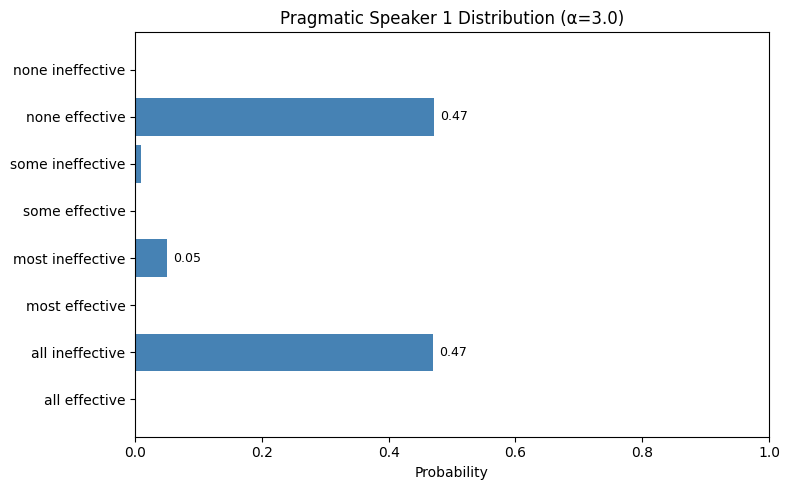

In [ ]:
plot_speaker_distribution(speaker1_dist, title="Pragmatic Speaker 1 Distribution", alpha=3.0)

In [52]:
print(obs)
for u, v in sorted(informativity_dict.items(), key=lambda x: -x[1]):
    if v > 0:
        print(f"{u}: {v}")


[[0 0 0 0 0 0 0]]
('none', 'most', 'ineffective'): 9.27627423442066e-09
('all', 'most', 'effective'): 9.247429340610746e-09
('some', 'none', 'ineffective'): 8.730990280507146e-09
('some', 'all', 'effective'): 8.72711786987095e-09
('most', 'most', 'effective'): 7.648487727680165e-09
('some', 'most', 'effective'): 5.599550822652746e-09
('none', 'none', 'effective'): 5.412106217144314e-09
('none', 'all', 'ineffective'): 5.387663477041723e-09
('all', 'some', 'effective'): 5.343900373712666e-09
('some', 'some', 'ineffective'): 4.555138495879732e-09
('most', 'some', 'effective'): 4.3944677758236834e-09
('most', 'some', 'ineffective'): 4.3670978726924015e-09
('some', 'some', 'effective'): 4.180856102150224e-09


In [35]:
obs = create_samples(0.8, 10, 5)
print("obs:\n", obs)

distribtuion = literal_speaker_utterance(obs)
def print_distribution(dist, threshold=0.0):
    print(f"{'Quantifier 1':<10} {'Quantifier 2':<10} {'Effectiveness':<12} {'Probability':<10}")
    print("-" * 50)
    
    for key, prob in sorted(dist.items(), key=lambda x: -x[1]):
        if prob >= threshold:
            q1, q2, eff = key
            print(f"{q1:<10} {q2:<10} {eff:<12} {prob:<10.3f}")
            
print_distribution(distribtuion, threshold=0.0)

obs:
 [[1 1 1 0 1]
 [1 1 1 0 0]
 [1 1 1 1 0]
 [1 0 1 1 1]
 [0 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 0 1 1]
 [1 0 1 1 1]]
Quantifier 1 Quantifier 2 Effectiveness Probability
--------------------------------------------------
all        most       effective    0.077     
all        some       effective    0.077     
most       most       effective    0.077     
most       some       effective    0.077     
some       all        effective    0.077     
some       most       effective    0.077     
some       some       effective    0.077     
none       none       effective    0.077     
most       some       ineffective  0.077     
some       some       ineffective  0.077     
some       none       ineffective  0.077     
none       all        ineffective  0.077     
none       most       ineffective  0.077     
all        all        effective    0.000     
all        none       effective    0.000     
most       all        effective    0.000     
most       none       ef

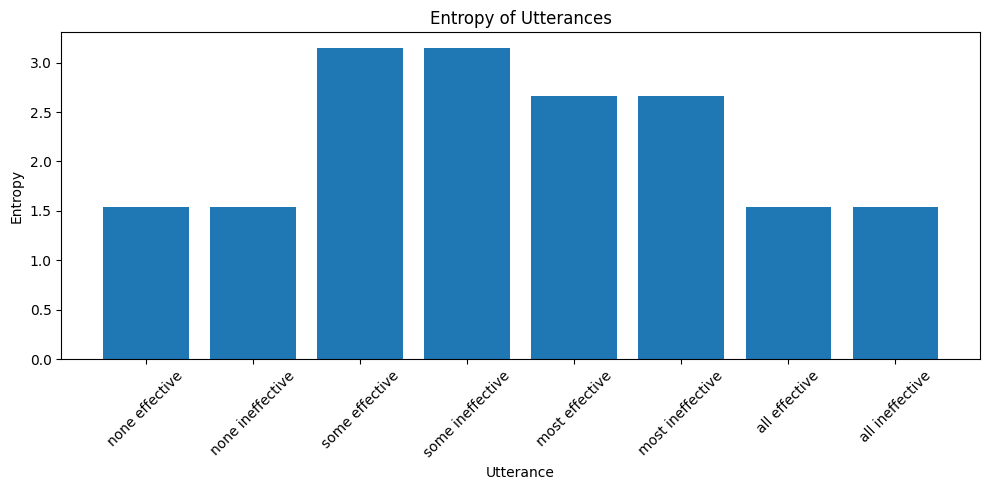

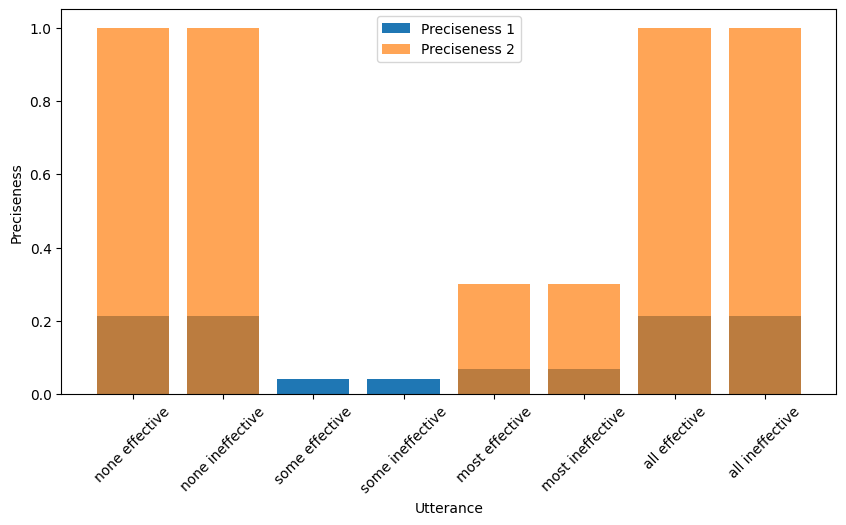

In [20]:
entropies = {}
utterances = list(product(quantifiers, predicates))
n = 1
m = 7
for utterance in utterances:
    dist = literal_listener_theta_utterance(utterance, n=n, m=m)
    entropy = -sum(p * np.log2(p) for p in dist if p > 0)
    entropies[utterance] = entropy

preciseness1 = {u: 1 / np.exp(ent) for u, ent in entropies.items()}
max_entropy = max(entropies.values())
min_entropy = min(entropies.values())
preciseness2 = {u: 1 - (ent - min_entropy) / (max_entropy - min_entropy) for u, ent in entropies.items()}


#plot entropies
plt.figure(figsize=(10, 5))
plt.bar(range(len(entropies)), list(entropies.values()), align='center')
plt.xticks(range(len(entropies)), [f"{q2} {pred}" for (q2, pred) in entropies.keys()], rotation=45)
plt.xlabel("Utterance")
plt.ylabel("Entropy")
plt.title("Entropy of Utterances")
plt.tight_layout()

#plot precisions
plt.figure(figsize=(10, 5))
plt.bar(range(len(preciseness1)), list(preciseness1.values()), align='center', label='Preciseness 1')
plt.bar(range(len(preciseness2)), list(preciseness2.values()), align='center', label='Preciseness 2', alpha=0.7)
plt.xticks(range(len(preciseness1)), [f"{q2} {pred}" for (q2, pred) in preciseness1.keys()], rotation=45)
plt.xlabel("Utterance")
plt.ylabel("Preciseness")
plt.legend()

In [ ]:
preciseness = {}
for interval_range in range(0, 101):
    